In [ ]:
# TensorFlow GPU memory growth is enabled to avoid allocation issues on some systems.
import tensorflow as tf

gpus = tf.config.experimental.list_physical_devices('GPU')
if gpus:
    try:
        for gpu in gpus:
            tf.config.experimental.set_memory_growth(gpu, True)
        print("Memory growth enabled")
    except RuntimeError as e:
        print("Error enabling memory growth:", e)

✅ Memory growth enabled


In [ ]:
# Core imports for model construction, data processing, and training routines.
from keras.layers import Input, Lambda, Dense, Flatten, Dropout, GlobalAveragePooling2D
from keras.models import Model, load_model
from keras.preprocessing import image
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from keras.models import Sequential
import numpy as np
from glob import glob
import matplotlib.pyplot as plt
from tensorflow.keras.applications import DenseNet121
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint
from tensorflow.keras.optimizers import Adam

In [ ]:
# Google Drive is mounted to access datasets stored in the cloud environment.
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
# Image size and dataset paths for training and validation sets.
IMAGE_SIZE = [224, 224]
train_path = '/content/drive/MyDrive/chest_xray/train'
valid_path = '/content/drive/MyDrive/chest_xray/test'

In [ ]:
# DenseNet121 base model is loaded with ImageNet weights, excluding the top layer for transfer learning.
base_model = DenseNet121(weights='imagenet', include_top=False, input_shape=(224, 224, 3))

29084464/29084464 ━━━━━━━━━━━━━━━━━━━━ 1s 0us/step


In [ ]:
# All layers in the base model are frozen to preserve pre-trained features during initial training.
for layer in base_model.layers:
    layer.trainable = False

In [ ]:
# Custom classification head is added on top of DenseNet for binary classification.
x = base_model.output
x = GlobalAveragePooling2D()(x)
x = Dropout(0.5)(x)
x = Dense(256, activation='relu')(x)
x = Dropout(0.3)(x)
predictions = Dense(2, activation='softmax')(x)

model_densenet = Model(inputs=base_model.input, outputs=predictions)

In [ ]:
# (Optional) Additional model configuration or summary can be placed here.

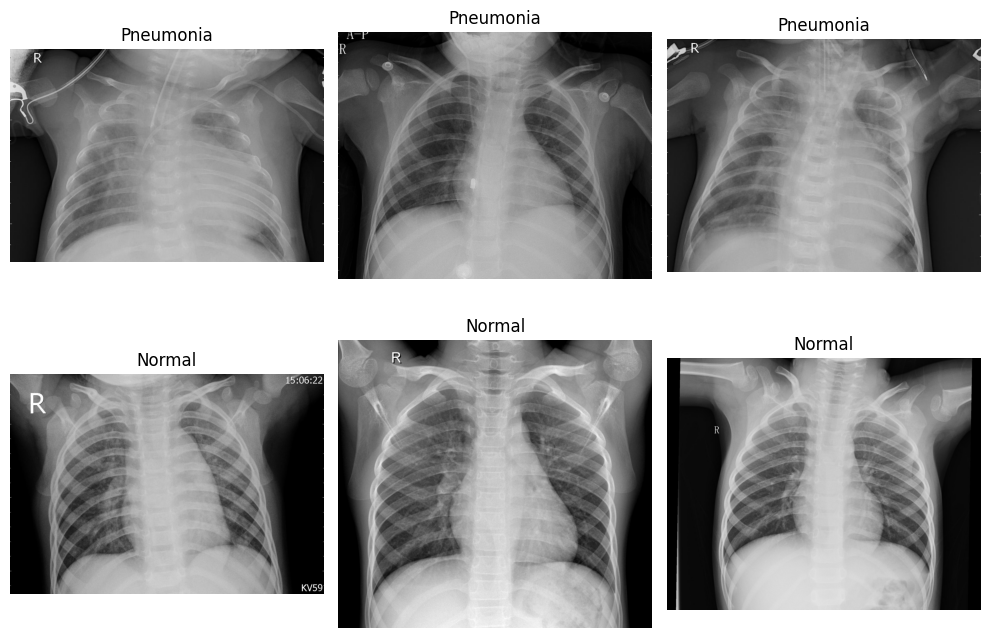

In [ ]:
import os
import random
import matplotlib.pyplot as plt
from tensorflow.keras.preprocessing.image import load_img, img_to_array

# Collects file paths for pneumonia and normal chest X-ray images from the test set.
pneumonia_dir = '/content/drive/MyDrive/chest_xray/test/PNEUMONIA'
normal_dir = '/content/drive/MyDrive/chest_xray/test/NORMAL'

pneumonia_images = [os.path.join(pneumonia_dir, img) for img in os.listdir(pneumonia_dir) if img.endswith(('jpg', 'png', 'jpeg'))]
normal_images = [os.path.join(normal_dir, img) for img in os.listdir(normal_dir) if img.endswith(('jpg', 'png', 'jpeg'))]

# Randomly samples images for visualization.
sample_pneumonia = random.sample(pneumonia_images, 3)
sample_normal = random.sample(normal_images, 3)

fig, axes = plt.subplots(2, 3, figsize=(10, 7))

for i, img_path in enumerate(sample_pneumonia):
    img = load_img(img_path)
    axes[0, i].imshow(img)
    axes[0, i].set_title("Pneumonia")
    axes[0, i].axis("off")

for i, img_path in enumerate(sample_normal):
    img = load_img(img_path)
    axes[1, i].imshow(img)
    axes[1, i].set_title("Normal")
    axes[1, i].axis("off")

plt.tight_layout()
plt.show()

In [ ]:
# Model summary provides an overview of the architecture and parameter count.
model_densenet.summary()

Model: "functional"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ input_layer         │ (None, 224, 224,  │          0 │ -                 │
│ (InputLayer)        │ 3)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ zero_padding2d      │ (None, 230, 230,  │          0 │ input_layer[0][0] │
│ (ZeroPadding2D)     │ 3)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv1_conv (Conv2D) │ (None, 112, 112,  │      9,408 │ zero_padding2d[0… │
│                     │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv1_bn            │ (None, 112, 112,  │        256 │ conv1_conv[0][0]  │
│ (BatchNormalizatio… │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv1_relu          │ (None, 112, 112,  │          0 │ conv1_bn[0][0]    │
│ (Activation)        │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ zero_padding2d_1    │ (None, 114, 114,  │          0 │ conv1_relu[0][0]  │
│ (ZeroPadding2D)     │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ pool1               │ (None, 56, 56,    │          0 │ zero_padding2d_1… │
│ (MaxPooling2D)      │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_0_bn   │ (None, 56, 56,    │        256 │ pool1[0][0]       │
│ (BatchNormalizatio… │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_0_relu │ (None, 56, 56,    │          0 │ conv2_block1_0_b… │
│ (Activation)        │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_1_conv │ (None, 56, 56,    │      8,192 │ conv2_block1_0_r… │
│ (Conv2D)            │ 128)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_1_bn   │ (None, 56, 56,    │        512 │ conv2_block1_1_c… │
│ (BatchNormalizatio… │ 128)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_1_relu │ (None, 56, 56,    │          0 │ conv2_block1_1_b… │
│ (Activation)        │ 128)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_2_conv │ (None, 56, 56,    │     36,864 │ conv2_block1_1_r… │
│ (Conv2D)            │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_concat │ (None, 56, 56,    │          0 │ pool1[0][0],      │
│ (Concatenate)       │ 96)               │            │ conv2_block1_2_c… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block2_0_bn   │ (None, 56, 56,    │        384 │ conv2_block1_con… │
│ (BatchNormalizatio… │ 96)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block2_0_relu │ (None, 56, 56,    │          0 │ conv2_block2_0_b… │
│ (Activation)        │ 96)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block2_1_conv │ (None, 56, 56,    │     12,288 │ conv2_block2_0_r

 Total params: 7,300,418 (27.85 MB)

 Trainable params: 262,914 (1.00 MB)

 Non-trainable params: 7,037,504 (26.85 MB)

In [ ]:
# Model is compiled with Adam optimizer and categorical crossentropy loss for multi-class classification.
model_densenet.compile(optimizer=Adam(learning_rate=1e-3),
                       loss='categorical_crossentropy',
                       metrics=['accuracy'])

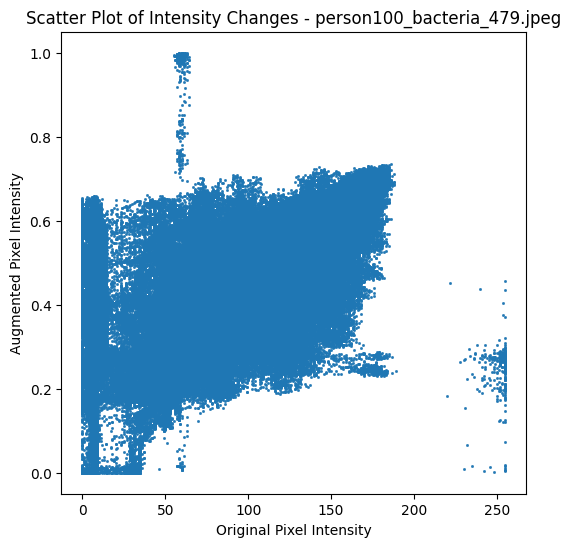

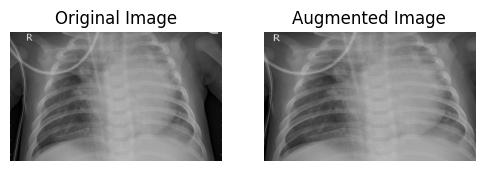

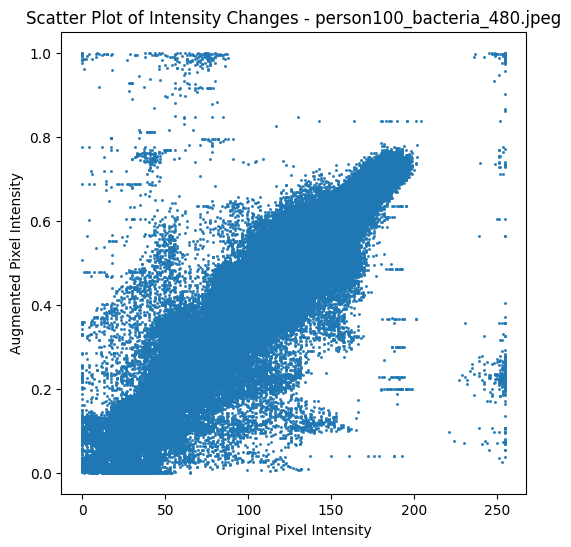

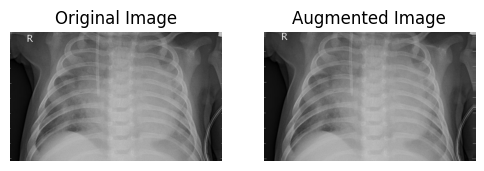

Found 5217 images belonging to 2 classes.
Found 1124 images belonging to 2 classes.


In [ ]:
import matplotlib.pyplot as plt
import numpy as np
import os
from tensorflow.keras.preprocessing.image import ImageDataGenerator, load_img, img_to_array

# Data augmentation is applied to both training and test sets for robustness.
train_datagen = ImageDataGenerator(rescale=1./255,
                                   shear_range=0.2,
                                   zoom_range=0.2,
                                   horizontal_flip=True)
test_datagen = ImageDataGenerator(rescale=1./255,
                                   shear_range=0.2,
                                   zoom_range=0.2,
                                   horizontal_flip=True)

dataset_path = '/content/drive/MyDrive/chest_xray/chest_xray/test/PNEUMONIA'
image_files = [f for f in os.listdir(dataset_path) if f.endswith(('jpg', 'png', 'jpeg'))]

# Visual comparison of original and augmented images for a subset of the data.
for img_file in image_files[:2]:
    img_path = os.path.join(dataset_path, img_file)
    original_img = load_img(img_path)
    img_array = img_to_array(original_img)
    img_array = np.expand_dims(img_array, axis=0)

    augmented_img = train_datagen.flow(img_array, batch_size=1)
    augmented_image_array = next(augmented_img)[0]

    # Scatter plot shows pixel intensity changes due to augmentation.
    original_pixels = img_array.flatten()
    augmented_pixels = augmented_image_array.flatten()

    plt.figure(figsize=(6, 6))
    plt.scatter(original_pixels, augmented_pixels, alpha=0.5, s=1)
    plt.xlabel("Original Pixel Intensity")
    plt.ylabel("Augmented Pixel Intensity")
    plt.title(f"Scatter Plot of Intensity Changes - {img_file}")
    plt.show()

    plt.figure(figsize=(6, 3))
    plt.subplot(1, 2, 1)
    plt.imshow(original_img)
    plt.title("Original Image")
    plt.axis("off")

    plt.subplot(1, 2, 2)
    plt.imshow(augmented_image_array.astype(np.uint8))
    plt.title("Augmented Image")
    plt.axis("off")
    plt.show()

# Data generators for model training and evaluation are created below.
training_set = train_datagen.flow_from_directory('/content/drive/MyDrive/chest_xray/train',
                                                 target_size = (224, 224),
                                                 batch_size = 64,
                                                 class_mode = 'categorical')

test_set = test_datagen.flow_from_directory('/content/drive/MyDrive/chest_xray/test',
                                            target_size = (224, 224),
                                            batch_size = 64,
                                            class_mode = 'categorical')

In [ ]:
# Model training with callbacks for learning rate reduction and early stopping.
from tensorflow.keras.callbacks import ReduceLROnPlateau, EarlyStopping

initial_history = model_densenet.fit(
    training_set,
    validation_data=test_set,
    epochs=5,
    callbacks=[
        ReduceLROnPlateau(patience=2, factor=0.2, verbose=1),
        EarlyStopping(patience=4, restore_best_weights=True)
    ])

/usr/local/lib/python3.11/dist-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


Epoch 1/5
82/82 ━━━━━━━━━━━━━━━━━━━━ 2664s 32s/step - accuracy: 0.7533 - loss: 0.6088 - val_accuracy: 0.8621 - val_loss: 0.3067 - learning_rate: 0.0010
Epoch 2/5
82/82 ━━━━━━━━━━━━━━━━━━━━ 154s 2s/step - accuracy: 0.8934 - loss: 0.2637 - val_accuracy: 0.8327 - val_loss: 0.3573 - learning_rate: 0.0010
Epoch 3/5
82/82 ━━━━━━━━━━━━━━━━━━━━ 0s 2s/step - accuracy: 0.8969 - loss: 0.2526
Epoch 3: ReduceLROnPlateau reducing learning rate to 0.00020000000949949026.
82/82 ━━━━━━━━━━━━━━━━━━━━ 167s 2s/step - accuracy: 0.8969 - loss: 0.2525 - val_accuracy: 0.8390 - val_loss: 0.3487 - learning_rate: 0.0010
Epoch 4/5
82/82 ━━━━━━━━━━━━━━━━━━━━ 154s 2s/step - accuracy: 0.8986 - loss: 0.2360 - val_accuracy: 0.8808 - val_loss: 0.2753 - learning_rate: 2.0000e-04
Epoch 5/5
82/82 ━━━━━━━━━━━━━━━━━━━━ 153s 2s/step - accuracy: 0.9053 - loss: 0.2215 - val_accuracy: 0.8870 - val_loss: 0.2667 - learning_rate: 2.0000e-04


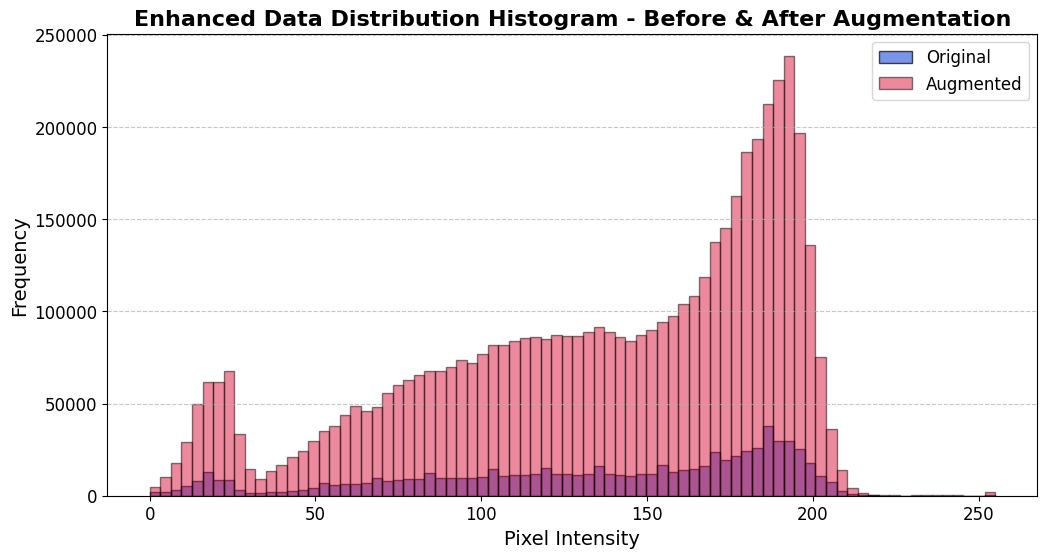

In [ ]:
import matplotlib.pyplot as plt
import numpy as np
import os
from tensorflow.keras.preprocessing.image import ImageDataGenerator, load_img, img_to_array

# Histogram comparison of pixel intensity distributions before and after augmentation.
train_datagen = ImageDataGenerator(
    rescale=1./255,
    shear_range=0.2,
    zoom_range=0.2,
    horizontal_flip=True,
)

dataset_path = '/content/drive/MyDrive/chest_xray/chest_xray/test/PNEUMONIA'  # Path to pneumonia images
image_files = [f for f in os.listdir(dataset_path) if f.endswith(('jpg', 'png', 'jpeg'))]

original_pixels = []
augmented_pixels = []

# Multiple images and augmentations are processed for a robust distribution view.
for img_file in image_files[:5]:
    img_path = os.path.join(dataset_path, img_file)
    original_img = load_img(img_path, target_size=(224, 224))
    img_array = img_to_array(original_img)
    img_array = np.expand_dims(img_array, axis=0)
    original_pixels.extend(img_array.flatten())
    for _ in range(7):
        augmented_img = train_datagen.flow(img_array, batch_size=1)
        aug_img_array = next(augmented_img)[0]
        augmented_pixels.extend(aug_img_array.flatten() * 255)

original_pixels = np.array(original_pixels)
augmented_pixels = np.array(augmented_pixels)

plt.figure(figsize=(12, 6))
plt.hist(original_pixels, bins=80, alpha=0.7, color='royalblue', label='Original', edgecolor='black')
plt.hist(augmented_pixels, bins=80, alpha=0.5, color='crimson', label='Augmented', edgecolor='black')
plt.xlabel('Pixel Intensity', fontsize=14)
plt.ylabel('Frequency', fontsize=14)
plt.title('Enhanced Data Distribution Histogram - Before & After Augmentation', fontsize=16, fontweight='bold')
plt.legend(fontsize=12)
plt.grid(axis='y', linestyle='--', alpha=0.7)
plt.xticks(fontsize=12)
plt.yticks(fontsize=12)
plt.show()

In [ ]:
# Model is recompiled with a lower learning rate for fine-tuning.
model_densenet.compile(optimizer=Adam(learning_rate=1e-5), loss='categorical_crossentropy', metrics=['accuracy'])

In [ ]:
# Selective layer unfreezing for fine-tuning deeper layers of the model.
unfreeze_from = len(model_densenet.layers) - 100

for layer in model_densenet.layers[:unfreeze_from]:
    layer.trainable = False
for layer in model_densenet.layers[unfreeze_from:]:
    layer.trainable = True

In [ ]:
# Fine-tuning the model with callbacks for adaptive learning and early stopping.
fine_tune_history = model_densenet.fit(
    training_set,
    validation_data=test_set,
    epochs=15,
    callbacks=[
        ReduceLROnPlateau(patience=2, factor=0.2, verbose=1),
        EarlyStopping(patience=4, restore_best_weights=True)
    ])

Epoch 1/15
82/82 ━━━━━━━━━━━━━━━━━━━━ 249s 2s/step - accuracy: 0.8434 - loss: 0.4962 - val_accuracy: 0.8950 - val_loss: 0.2825 - learning_rate: 1.0000e-05
Epoch 2/15
82/82 ━━━━━━━━━━━━━━━━━━━━ 169s 2s/step - accuracy: 0.9124 - loss: 0.2515 - val_accuracy: 0.9012 - val_loss: 0.2882 - learning_rate: 1.0000e-05
Epoch 3/15
82/82 ━━━━━━━━━━━━━━━━━━━━ 0s 2s/step - accuracy: 0.9272 - loss: 0.2010
Epoch 3: ReduceLROnPlateau reducing learning rate to 1.9999999494757505e-06.
82/82 ━━━━━━━━━━━━━━━━━━━━ 157s 2s/step - accuracy: 0.9271 - loss: 0.2012 - val_accuracy: 0.9048 - val_loss: 0.2897 - learning_rate: 1.0000e-05
Epoch 4/15
82/82 ━━━━━━━━━━━━━━━━━━━━ 175s 2s/step - accuracy: 0.9251 - loss: 0.1968 - val_accuracy: 0.9066 - val_loss: 0.2745 - learning_rate: 2.0000e-06
Epoch 5/15
82/82 ━━━━━━━━━━━━━━━━━━━━ 192s 2s/step - accuracy: 0.9268 - loss: 0.1991 - val_accuracy: 0.9057 - val_loss: 0.2806 - learning_rate: 2.0000e-06
Epoch 6/15
82/82 ━━━━━━━━━━━━━━━━━━━━ 176s 2s/step - accuracy: 0.9330 - loss

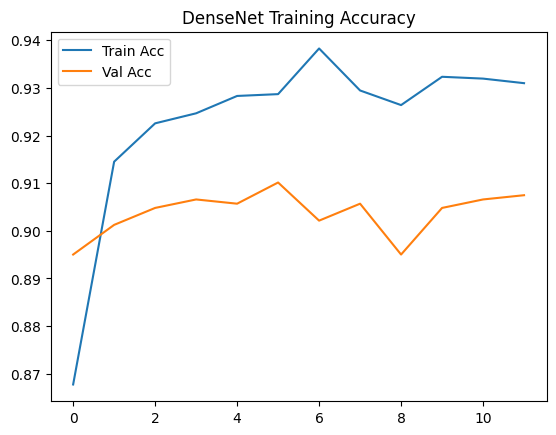

In [ ]:
# Visualization of training and validation accuracy during fine-tuning.
plt.plot(fine_tune_history.history['accuracy'], label='Train Acc')
plt.plot(fine_tune_history.history['val_accuracy'], label='Val Acc')
plt.legend()
plt.title('DenseNet Training Accuracy')
plt.show()

In [ ]:
# Model is saved to disk for later inference or evaluation.
import tensorflow as tf
from keras.models import load_model
model_densenet.save('denseNetFpneumonia.h5')

/usr/local/lib/python3.11/dist-packages/keras/src/models/functional.py:237: UserWarning: The structure of `inputs` doesn't match the expected structure.
Expected: [['input_layer']]
Received: inputs=Tensor(shape=(1, 224, 224, 3))
  warnings.warn(msg)


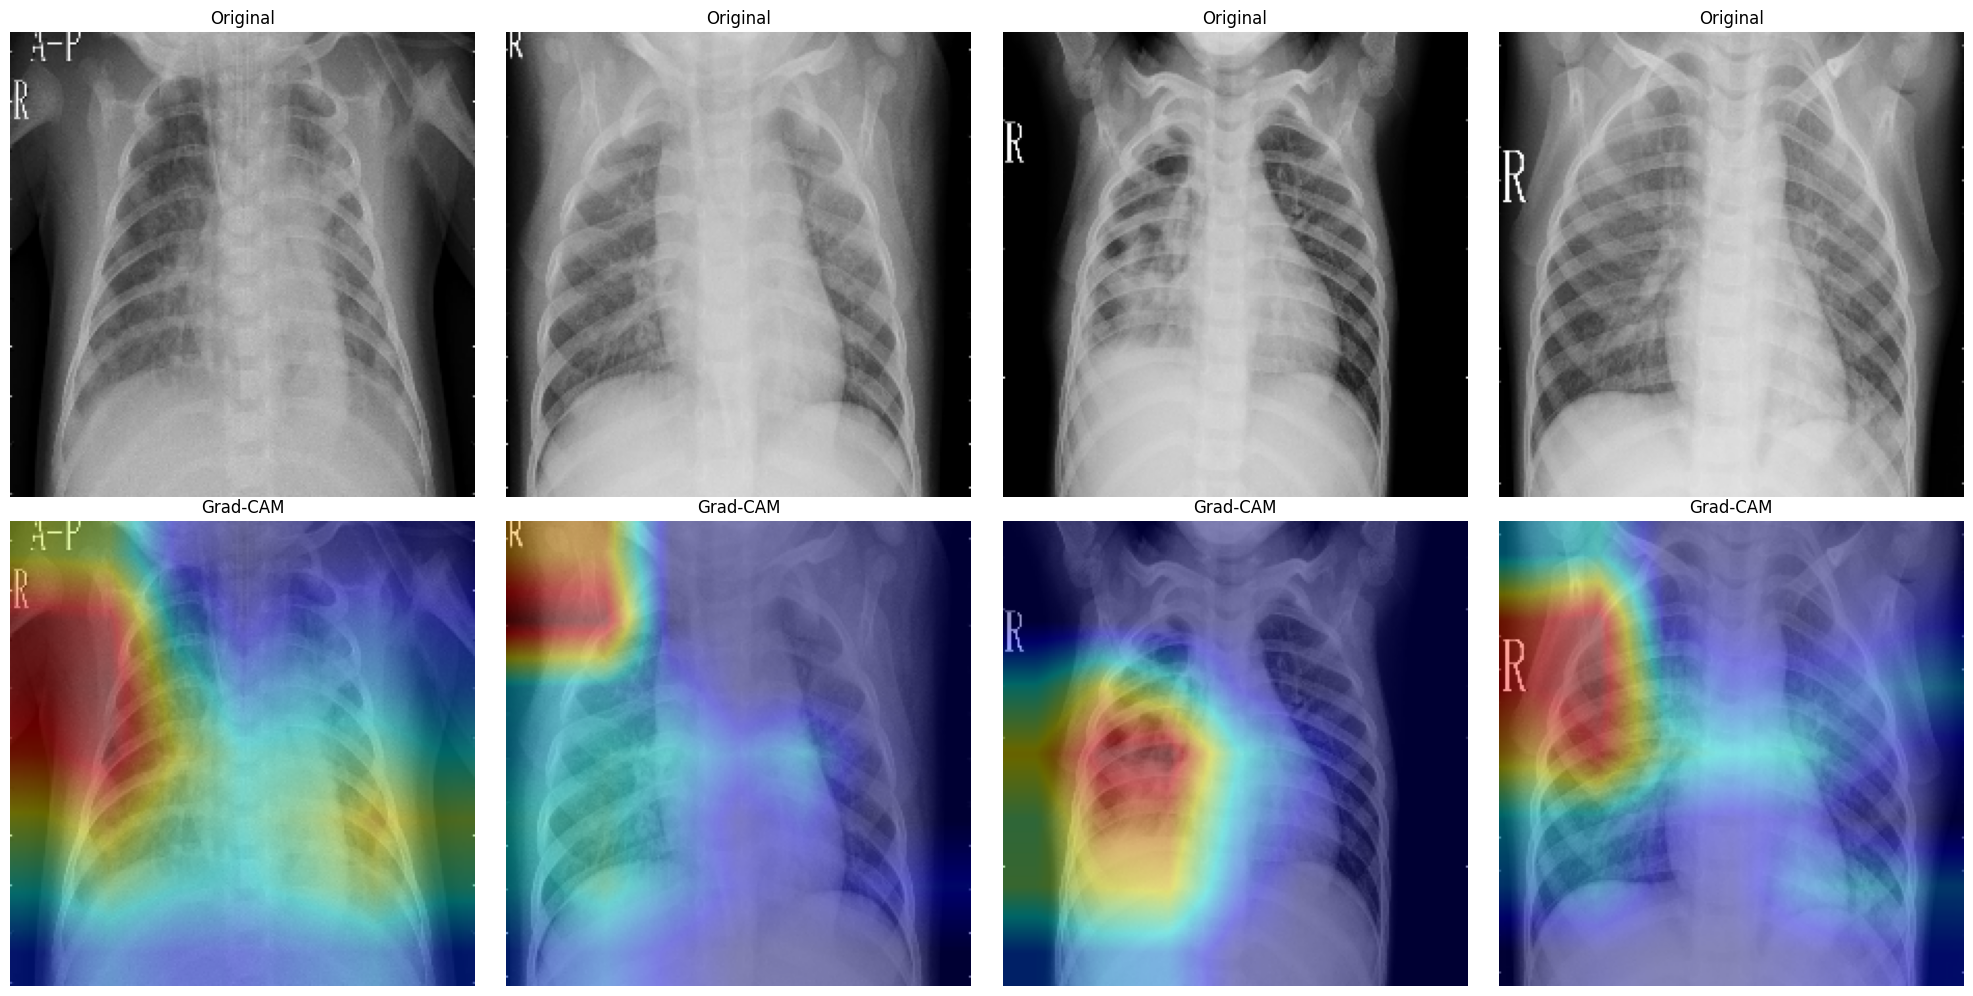

Found 1124 images belonging to 2 classes.


/usr/local/lib/python3.11/dist-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


36/36 ━━━━━━━━━━━━━━━━━━━━ 35s 683ms/step


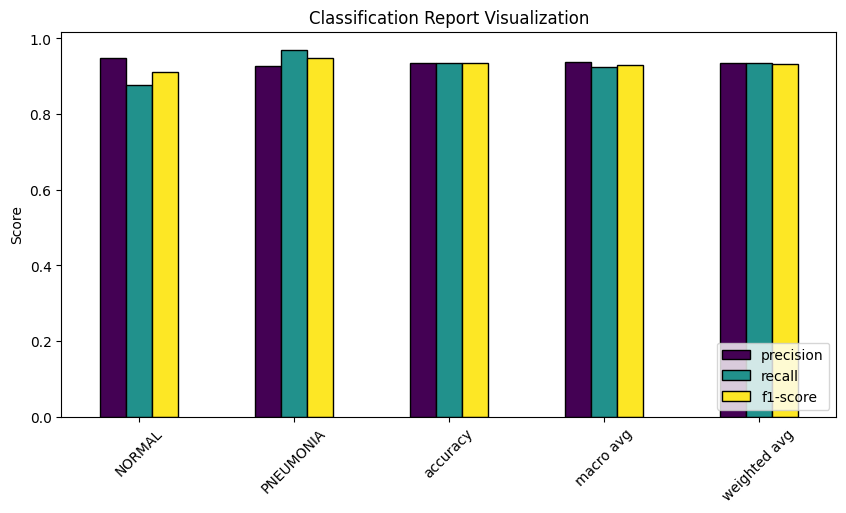

In [ ]:
import numpy as np
import os
import cv2
import matplotlib.pyplot as plt
import tensorflow as tf
from tensorflow.keras.models import Model, load_model
from tensorflow.keras.preprocessing.image import load_img, img_to_array, ImageDataGenerator
from sklearn.metrics import confusion_matrix, classification_report
import seaborn as sns
import pandas as pd

# Grad-CAM visualization for model interpretability and classification report plotting.
model = load_model('denseNetFpneumonia.h5')

def generate_gradcam(model, img_array, layer_name):
    grad_model = Model(inputs=[model.inputs], outputs=[model.get_layer(layer_name).output, model.output])
    with tf.GradientTape() as tape:
        conv_output, predictions = grad_model(img_array)
        class_idx = np.argmax(predictions[0])
        loss = predictions[:, class_idx]
    grads = tape.gradient(loss, conv_output)
    pooled_grads = tf.reduce_mean(grads, axis=(0, 1, 2))
    conv_output = conv_output.numpy()[0]
    heatmap = np.mean(conv_output * pooled_grads.numpy(), axis=-1)
    heatmap = np.maximum(heatmap, 0)
    heatmap /= np.max(heatmap)
    return heatmap

def overlay_gradcam(img, heatmap, alpha=0.4):
    heatmap = cv2.resize(heatmap, (img.shape[1], img.shape[0]))
    heatmap = np.uint8(255 * heatmap)
    heatmap = cv2.applyColorMap(heatmap, cv2.COLORMAP_JET)
    superimposed_img = cv2.addWeighted(img, 1 - alpha, heatmap, alpha, 0)
    return superimposed_img

test_images = [
    '/content/drive/MyDrive/chest_xray/val/PNEUMONIA/person1946_bacteria_4874.jpeg',
    '/content/drive/MyDrive/chest_xray/val/PNEUMONIA/person1947_bacteria_4876.jpeg',
    '/content/drive/MyDrive/chest_xray/val/PNEUMONIA/person1954_bacteria_4886.jpeg',
    '/content/drive/MyDrive/chest_xray/val/PNEUMONIA/person1950_bacteria_4881.jpeg'
    ]

fig, axes = plt.subplots(2, len(test_images), figsize=(20, 10))
for i, img_path in enumerate(test_images):
    img = cv2.imread(img_path)
    img = cv2.resize(img, (224, 224))
    img_array = np.expand_dims(img, axis=0) / 255.0
    heatmap = generate_gradcam(model, img_array, 'conv5_block16_concat')
    gradcam_result = overlay_gradcam(img, heatmap)
    axes[0, i].imshow(cv2.cvtColor(img, cv2.COLOR_BGR2RGB))
    axes[0, i].set_title('Original')
    axes[0, i].axis('off')
    axes[1, i].imshow(cv2.cvtColor(gradcam_result, cv2.COLOR_BGR2RGB))
    axes[1, i].set_title('Grad-CAM')
    axes[1, i].axis('off')
plt.tight_layout()
plt.show()

# Classification report is visualized as a bar plot for easier comparison of metrics.
IMAGE_SIZE = (224, 224)
test_datagen = ImageDataGenerator(rescale=1./255)
test_set = test_datagen.flow_from_directory('/content/drive/MyDrive/chest_xray/test', target_size=IMAGE_SIZE, batch_size=32, class_mode='categorical', shuffle=False)
true_labels = test_set.classes
predictions = model.predict(test_set)
predicted_labels = np.argmax(predictions, axis=1)
report = classification_report(true_labels, predicted_labels, target_names=test_set.class_indices.keys(), output_dict=True)
report_df = pd.DataFrame(report).transpose()
report_df.drop(columns=['support'], inplace=True)
report_df.plot(kind='bar', figsize=(10, 5), colormap='viridis', edgecolor='black')
plt.title('Classification Report Visualization')
plt.xticks(rotation=45)
plt.ylabel('Score')
plt.legend(loc='lower right')
plt.show()

Found 1124 images belonging to 2 classes.


/usr/local/lib/python3.11/dist-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


36/36 ━━━━━━━━━━━━━━━━━━━━ 44s 767ms/step


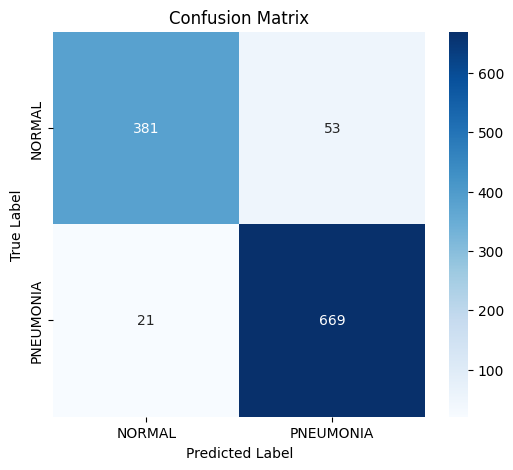

              precision    recall  f1-score   support

      NORMAL     0.9478    0.8779    0.9115       434
   PNEUMONIA     0.9266    0.9696    0.9476       690

    accuracy                         0.9342      1124
   macro avg     0.9372    0.9237    0.9295      1124
weighted avg     0.9348    0.9342    0.9336      1124



In [ ]:
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from keras.models import load_model
from tensorflow.keras.preprocessing.image import ImageDataGenerator

from sklearn.metrics import confusion_matrix, classification_report

# Confusion matrix and classification report for model evaluation on the test set.
model = load_model('denseNetFpneumonia.h5')

IMAGE_SIZE = (224, 224)
test_datagen = ImageDataGenerator(rescale=1./255)
test_set = test_datagen.flow_from_directory(
    '/content/drive/MyDrive/chest_xray/test',
    target_size=IMAGE_SIZE,
    batch_size=32,
    class_mode='categorical',
    shuffle=False
)
true_labels = test_set.classes
predictions = model.predict(test_set)
predicted_labels = np.argmax(predictions, axis=1)
cm = confusion_matrix(true_labels, predicted_labels)
plt.figure(figsize=(6, 5))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=test_set.class_indices.keys(), yticklabels=test_set.class_indices.keys())
plt.xlabel('Predicted Label')
plt.ylabel('True Label')
plt.title('Confusion Matrix')
plt.show()
print(classification_report(true_labels, predicted_labels, target_names=test_set.class_indices.keys(),digits=4))

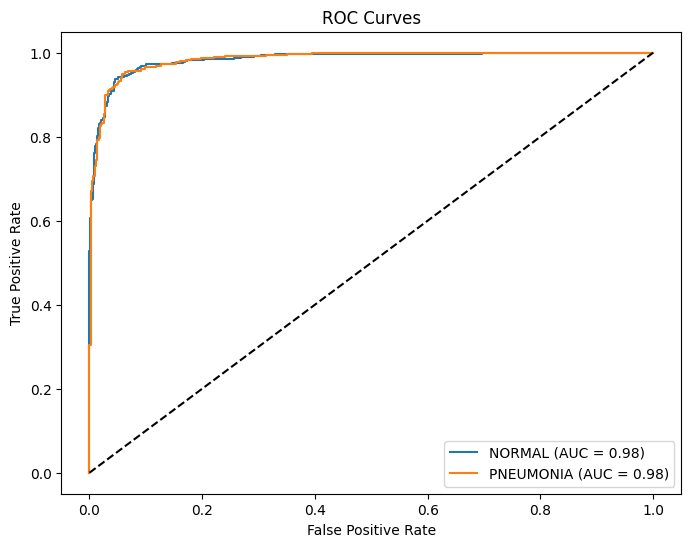

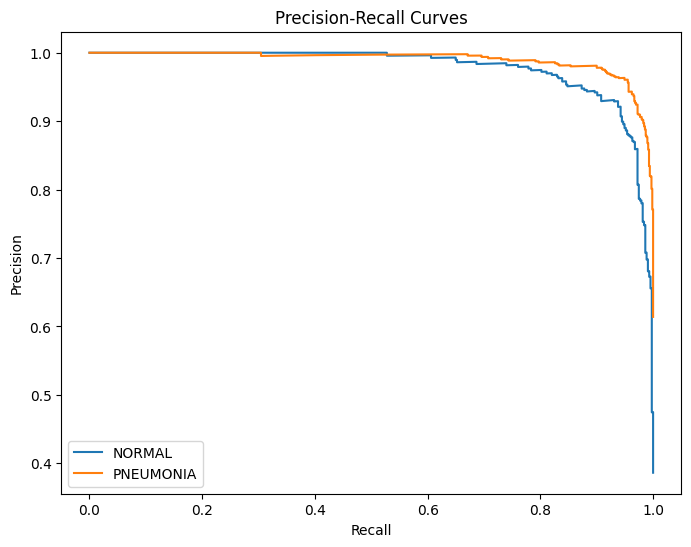

In [ ]:
# ROC and Precision-Recall curves for each class to assess model discrimination and precision-recall tradeoff.
from sklearn.metrics import roc_curve, auc
plt.figure(figsize=(8, 6))
for i, label in enumerate(test_set.class_indices.keys()):
    fpr, tpr, _ = roc_curve(true_labels == i, predictions[:, i])
    roc_auc = auc(fpr, tpr)
    plt.plot(fpr, tpr, label=f'{label} (AUC = {roc_auc:.2f})')
plt.plot([0, 1], [0, 1], 'k--')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curves')
plt.legend()
plt.show()

from sklearn.metrics import precision_recall_curve
plt.figure(figsize=(8, 6))
for i, label in enumerate(test_set.class_indices.keys()):
    precision, recall, _ = precision_recall_curve(true_labels == i, predictions[:, i])
    plt.plot(recall, precision, label=f'{label}')
plt.xlabel('Recall')
plt.ylabel('Precision')
plt.title('Precision-Recall Curves')
plt.legend()
plt.show()

1/1 ━━━━━━━━━━━━━━━━━━━━ 11s 11s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 52ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 52ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 67ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 64ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 149ms/step
Skipping /content/drive/MyDrive/chest_xray/val/PNEUMONIA/person1954_bacteria_4886.jpeg: num must be an integer with 1 <= num <= 10, not 11
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 71ms/step
Skipping /content/drive/MyDrive/chest_xray/val/PNEUMONIA/person1947_bacteria_4876.jpeg: num must be an integer with 1 <= num <= 10, not 13
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 87ms/step
Skipping /content/drive/MyDrive/chest_xray/val/PNEUMONIA/person1952_bacteria_4883.jpeg: num must be an integer with 1 <= num <= 10, not 15
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 104ms/step
Skipping /content/drive/MyDrive/chest_xray/val/NORMAL/NORMAL2-IM-1430-0001.jpeg: num must be an integer with 1 <= num <= 10, not 17
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 58ms/step
Skipping /content/drive/MyDrive/chest_xray/val/NORMAL/NORMAL2-IM-1438

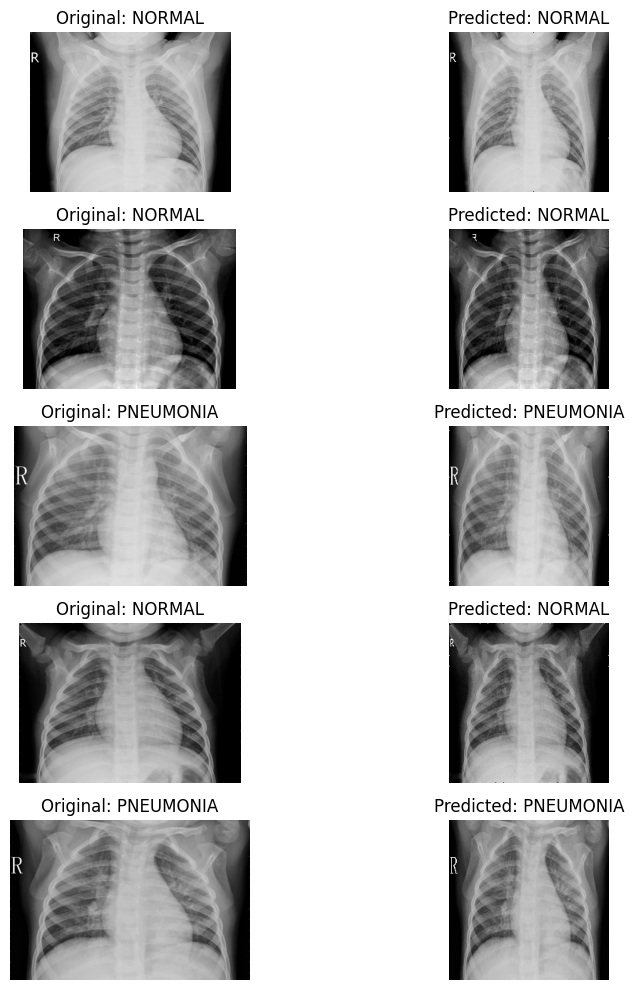

In [ ]:
import numpy as np
import os
import matplotlib.pyplot as plt
from tensorflow.keras.models import load_model
from tensorflow.keras.preprocessing.image import load_img, img_to_array

# Visual inspection of predictions on a random sample of test images from both classes.
model = load_model('denseNetFpneumonia.h5')

IMAGE_SIZE = (224, 224)
class_labels = ['NORMAL', 'PNEUMONIA']  # Adjust based on dataset classes
test_images_dir = '/content/drive/MyDrive/chest_xray/val'

pneumonia_images = [os.path.join(test_images_dir, 'PNEUMONIA', img) for img in os.listdir(os.path.join(test_images_dir, 'PNEUMONIA')) if img.endswith(('jpg', 'png', 'jpeg'))]
normal_images = [os.path.join(test_images_dir, 'NORMAL', img) for img in os.listdir(os.path.join(test_images_dir, 'NORMAL')) if img.endswith(('jpg', 'png', 'jpeg'))]
test_images = pneumonia_images + normal_images
np.random.shuffle(test_images)

plt.figure(figsize=(10, 10))
for i, img_path in enumerate(test_images[:10]):
    try:
        img = load_img(img_path, target_size=IMAGE_SIZE)
        img_array = img_to_array(img) / 255.0
        img_array = np.expand_dims(img_array, axis=0)
        prediction = model.predict(img_array)
        predicted_label = class_labels[np.argmax(prediction)]
        actual_label = "PNEUMONIA" if "PNEUMONIA" in img_path else "NORMAL"
        plt.subplot(5, 2, 2 * i + 1)
        plt.imshow(load_img(img_path))
        plt.title(f"Original: {actual_label}")
        plt.axis('off')
        plt.subplot(5, 2, 2 * i + 2)
        plt.imshow(img)
        plt.title(f"Predicted: {predicted_label}")
        plt.axis('off')
    except Exception as e:
        print(f"Skipping {img_path}: {e}")
plt.tight_layout()
plt.show()